In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import BayesianRidge

from darts.models import (
    LinearRegressionModel,
    RegressionModel,
    LightGBMModel,
    XGBModel,
    CatBoostModel,
    RandomForest
)
from darts.metrics import mape
from darts.datasets import ElectricityConsumptionZurichDataset
from darts.explainability import ShapExplainer

c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\User\anaconda3\envs\conda_dart\Lib\site-packages\statsforecast\utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [2]:
import pandas as pd

# อ่านข้อมูลจากไฟล์ CSV
df = pd.read_csv('csv/Ming13Jun67_total_order.csv')

# แปลงคอลัมน์ order_completed_at เป็น datetime
df['order_completed_at'] = pd.to_datetime(df['order_completed_at'])

# แสดงข้อมูลเบื้องต้นของ DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_completed_at  529 non-null    datetime64[ns]
 1   unique_order_count  529 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 8.4 KB


In [3]:
print(df.head())
print(df.tail())

  order_completed_at  unique_order_count
0         2023-01-01                  15
1         2023-01-02                  32
2         2023-01-03                  89
3         2023-01-04                  73
4         2023-01-05                  67
    order_completed_at  unique_order_count
524         2024-06-08                 124
525         2024-06-09                 115
526         2024-06-10                 113
527         2024-06-11                 132
528         2024-06-12                 136


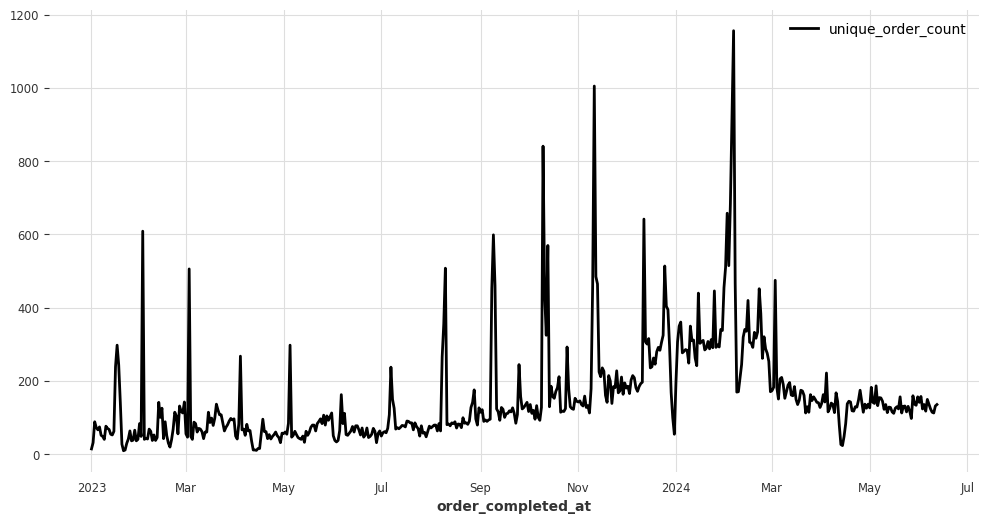

In [4]:
from darts import TimeSeries

ts_order_quantity = TimeSeries.from_dataframe(df, 'order_completed_at', 'unique_order_count')

# resample to hourly frequency
ts_order_quantity = ts_order_quantity.resample(freq="D")

ts_order = ts_order_quantity["unique_order_count"]

# create train and validation splits
validation_cutoff = pd.Timestamp("2024-05-31")
ts_training, ts_validation = ts_order.split_after(validation_cutoff)
ts_cov_train,ts_cov_test  = ts_order.split_after(validation_cutoff)

plt.figure(figsize=(12, 6))  
ts_order.plot()
plt.show()



# Linear Regression

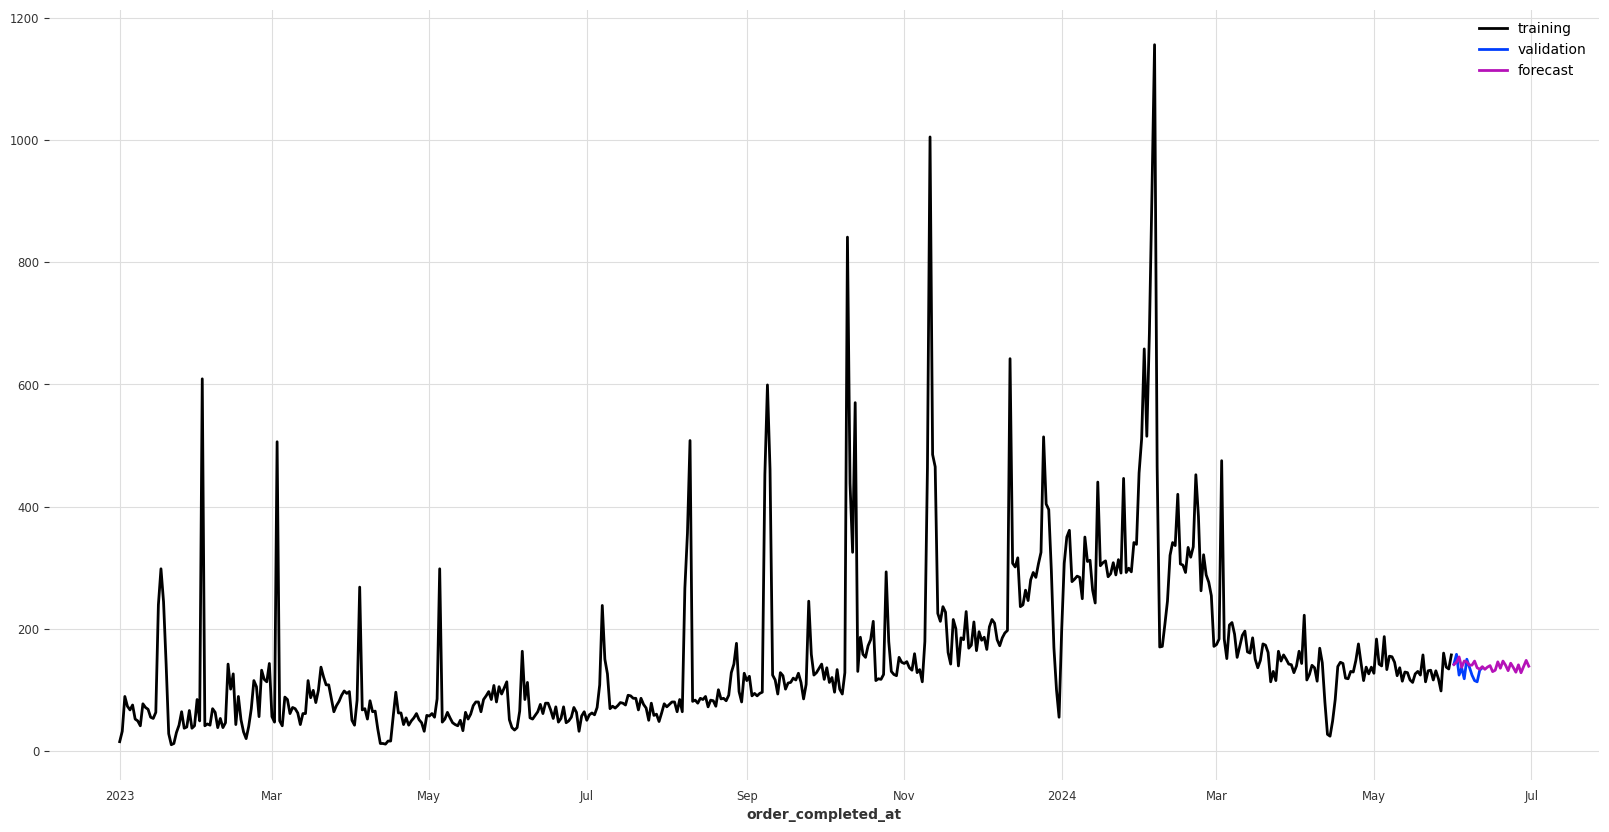

In [9]:
model = LinearRegressionModel(lags=33)
model.fit(ts_training)
pred = model.predict(30)

plt.figure(figsize=(20, 10)) 

ts_training.plot(label="training")
ts_validation.plot(label="validation")
pred.plot(label="forecast")


plt.show()

In [12]:
from darts.metrics import mape, mse, mae, rmse
pred_lr = model.predict(len(ts_validation))

print(f'Linear Regression MAPE: lag {33} {mape(ts_validation, pred_lr)}')
print(f'MSE {mse(ts_validation, pred_lr)}')
print(f'MAE {mae(ts_validation, pred_lr)}')
print(f'RMSE {rmse(ts_validation, pred_lr)}')

Linear Regression MAPE: lag 33 10.59077418378866
MSE 312.47390394111056
MAE 12.970513391683811
RMSE 17.676931406245558


In [13]:
# Predict
best_model = LinearRegressionModel.load('model/linearRegressionModel_totalOrder_13Jun67.pkl')
best_model.fit(ts_order_quantity)

# ts_order_quantity.pd_dataframe().tail()

forecast = best_model.predict(7)
forecast = forecast.pd_dataframe().reset_index()
forecast.columns = ['Date', 'Total Order']
forecast.tail(7)

,Date,Total Order
0,2024-06-13,129.342732
1,2024-06-14,136.427896
2,2024-06-15,134.443274
3,2024-06-16,125.433652
4,2024-06-17,127.198907
5,2024-06-18,139.391166
6,2024-06-19,133.014325


In [193]:
from darts.models import LinearRegressionModel, Prophet

best_model.save("model/linearRegressionModel_totalOrder_13Jun67.pkl")

# Linear Single Model, Multi Model

In [176]:
from darts.metrics import mape, mse, mae, rmse

def find_best_chunk_len(len_chunk:int):
    best_value = {"chunk":1, "value":0} #num chunk, error value (mape)
    for i in range(1,len_chunk+1):
        multi_models = LinearRegressionModel(lags=33, output_chunk_length=len_chunk, multi_models=True)
        multi_models.fit(ts_training)
        pred_multi_models = multi_models.predict(len(ts_validation))
        
        if i==1:
            best_value["value"] = mape(ts_validation, pred_multi_models)
        else:
            if best_value["value"] > mape(ts_validation, pred_multi_models) : 
                best_value["chunk"]=i; best_value["value"]=mape(ts_validation, pred_multi_models)
        
        return best_value

out = find_best_chunk_len(60)
print(f"chunk {out["chunk"]} mape: {out["value"]}")


chunk 1 mape: 12.22318449252503


<Axes: xlabel='order_completed_at'>

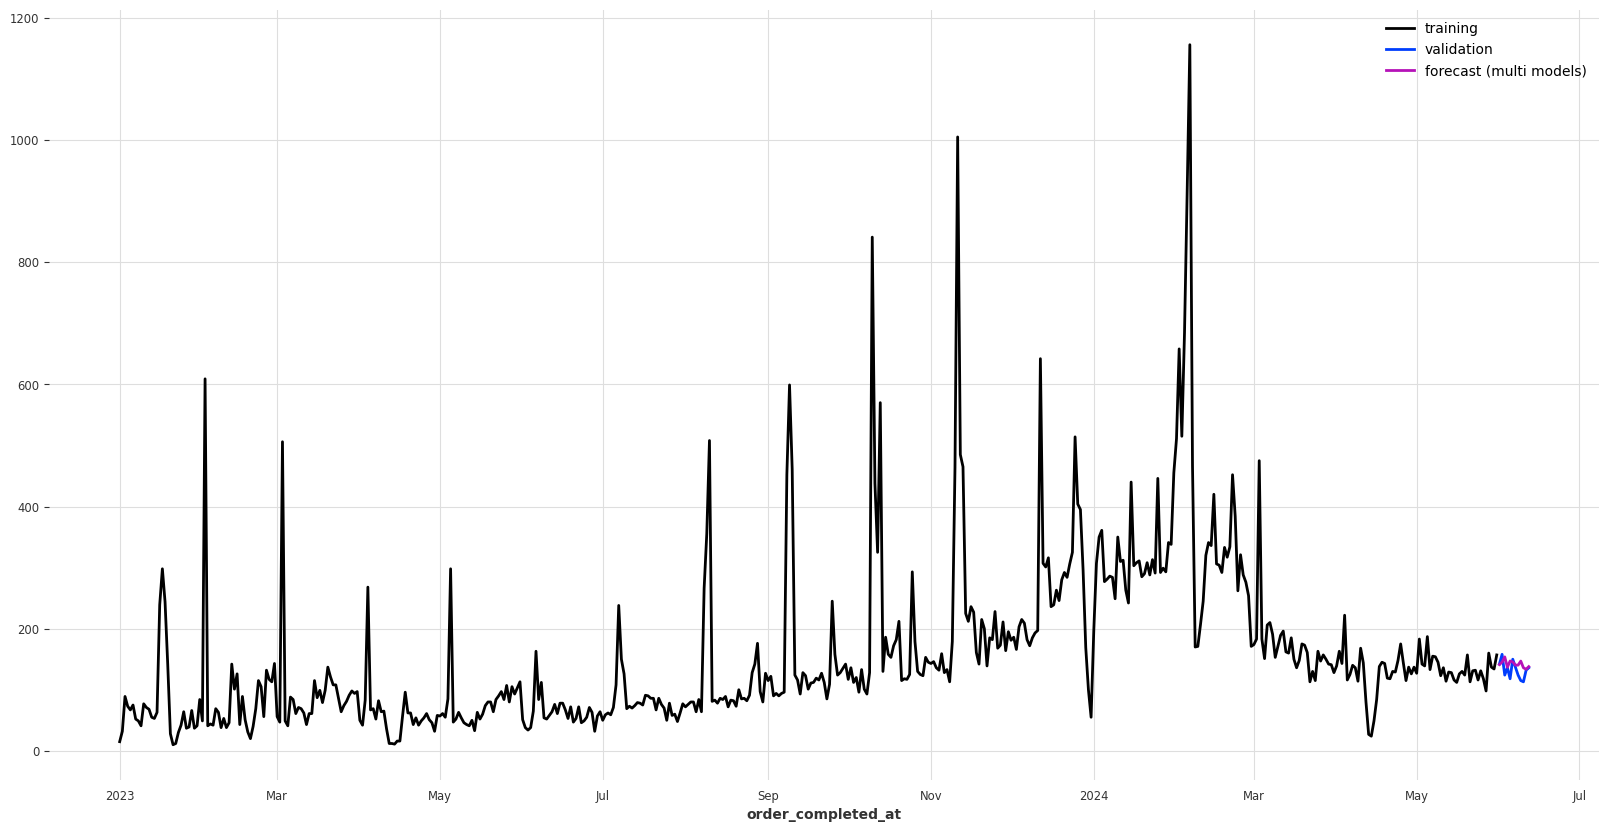

In [177]:

multi_models = LinearRegressionModel(lags=33, output_chunk_length=1, multi_models=True)
multi_models.fit(ts_training)

pred_multi_models = multi_models.predict(len(ts_validation))

plt.figure(figsize=(20, 10)) 
ts_training.plot(label="training")
ts_validation.plot(label="validation")
pred_multi_models.plot(label="forecast (multi models)")

In [179]:
print(f'Linear Regression Multi Model MAPE: lag {33} {mape(ts_validation, pred_multi_models)}')
print(f'MSE {mse(ts_validation, pred_multi_models)}')
print(f'MAE {mae(ts_validation, pred_multi_models)}')
print(f'RMSE {rmse(ts_validation, pred_multi_models)}')

Linear Regression Multi Model MAPE: lag 33 10.59077418378866
MSE 312.47390394111056
MAE 12.970513391683811
RMSE 17.676931406245558


In [180]:
from darts.metrics import mape, mse, mae, rmse

def find_best_chunk_len(len_chunk:int):
    best_value = {"chunk":1, "value":0} #num chunk, error value (mape)
    for i in range(1,len_chunk+1):
        single_models = LinearRegressionModel(lags=33, output_chunk_length=len_chunk, multi_models=False)
        single_models.fit(ts_training)
        pred_single_models = single_models.predict(len(ts_validation))
        
        if i==1:
            best_value["value"]=mape(ts_validation, pred_single_models)
        else:
            if best_value["value"]>pred_single_models : 
                best_value["chunk"]=i; best_value["value"]=pred_single_models
        
        return best_value

out = find_best_chunk_len(60)
print(f"chunk {out["chunk"]} mape: {out["value"]}")


chunk 1 mape: 19.715944818797443


<Axes: xlabel='order_completed_at'>

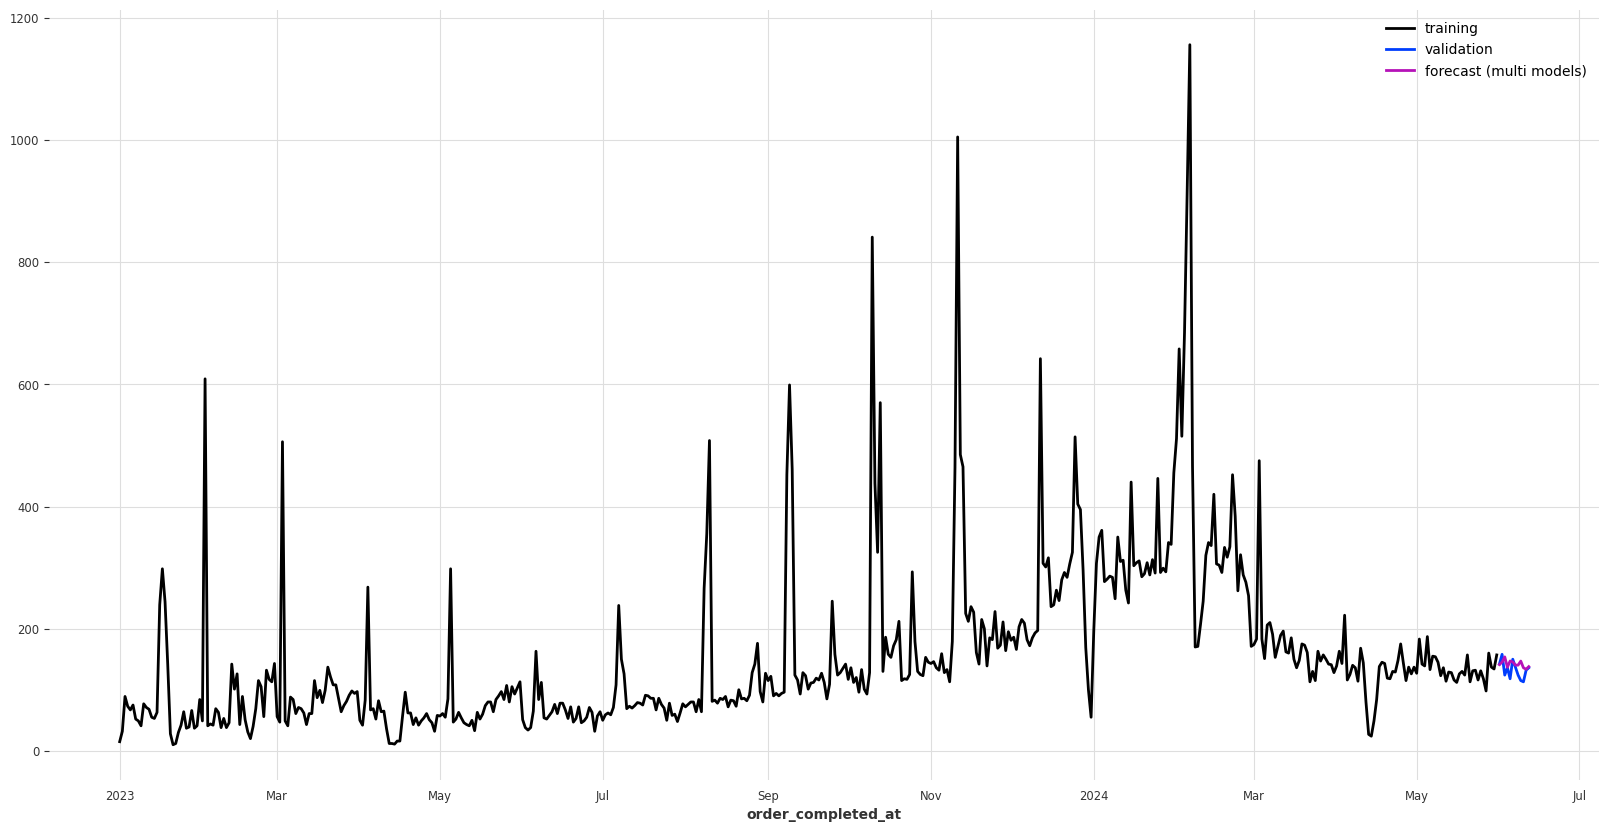

In [181]:

single_models = LinearRegressionModel(lags=33, output_chunk_length=1, multi_models=False)
single_models.fit(ts_training)

pred_single_models = single_models.predict(len(ts_validation))

plt.figure(figsize=(20, 10)) 
ts_training.plot(label="training")
ts_validation.plot(label="validation")
pred_single_models.plot(label="forecast (multi models)")

In [182]:
print(f'Linear Regression Single Model MAPE: lag {33} {mape(ts_validation, pred_single_models)}')
print(f'MSE {mse(ts_validation, pred_single_models)}')
print(f'MAE {mae(ts_validation, pred_single_models)}')
print(f'RMSE {rmse(ts_validation, pred_single_models)}')

Linear Regression Single Model MAPE: lag 33 10.59077418378866
MSE 312.47390394111056
MAE 12.970513391683811
RMSE 17.676931406245558


# Random Forest Model

In [15]:
from darts.models import (
    LinearRegressionModel,
    RegressionModel,
    LightGBMModel,
    XGBModel,
    CatBoostModel,
    RandomForest
)

# สร้างและฝึก Linear Regression Model
best_lag = 1
for i in range(1,31):
    model_Rforest = RandomForest(lags=i)
    model_Rforest.fit(ts_training)

    # ทำนายค่าใน validation set
    pred_Rforest = model_Rforest.predict(len(ts_validation))

    # คำนวณค่า MAPE (Mean Absolute Percentage Error)
    error = mape(ts_validation, pred_Rforest)
    if i==1:
        error_best= error
    else:
        if error < error_best:
            error_best = error; best_lag = i
print(f'Random Forest MAPE: lag {best_lag} MAPE {error_best}\n')

model_Rforest = RandomForest(lags=best_lag)
model_Rforest.fit(ts_training)
pred_Rforest = model_Rforest.predict(len(ts_validation))

print(f'Train Random Forest MAPE: lag {best_lag} MAPE {mape(ts_validation, pred_Rforest)}')
print(f'MSE {mse(ts_validation, pred_Rforest)}')
print(f'MAE {mae(ts_validation, pred_Rforest)}')
print(f'RMSE {rmse(ts_validation, pred_Rforest)}')

Random Forest MAPE: lag 27 MAPE 7.696256345497432

Train Random Forest MAPE: lag 27 MAPE 8.193247407927553
MSE 195.13484166666672
MAE 11.130833333333335
RMSE 13.969067315560718


In [17]:
best_depth = 1
for i in range(1,31):
    model_Rforest = RandomForest(lags=27, max_depth=i)
    model_Rforest.fit(ts_training)

    # ทำนายค่าใน validation set
    pred_Rforest = model_Rforest.predict(len(ts_validation))

    # คำนวณค่า MAPE (Mean Absolute Percentage Error)
    error = mape(ts_validation, pred_Rforest)
    if i==1:
        error_best= error
    else:
        if error < error_best:
            error_best = error;best_depth = i
    print(f'Random Forest MAPE: depth {best_depth} MAPE {error_best}\n')

model_Rforest = RandomForest(lags=27, max_depth=best_depth)
model_Rforest.fit(ts_training)
pred_Rforest = model_Rforest.predict(len(ts_validation))

print(f'Train Random Forest MAPE: depth {best_depth} MAPE {mape(ts_validation, pred_Rforest)}')
print(f'MSE {mse(ts_validation, pred_Rforest)}')
print(f'MAE {mae(ts_validation, pred_Rforest)}')
print(f'RMSE {rmse(ts_validation, pred_Rforest)}')

Random Forest MAPE: depth 1 MAPE 13.967914527355916

Random Forest MAPE: depth 2 MAPE 10.66949666202468

Random Forest MAPE: depth 2 MAPE 10.66949666202468

Random Forest MAPE: depth 4 MAPE 9.925408203769953

Random Forest MAPE: depth 4 MAPE 9.925408203769953

Random Forest MAPE: depth 6 MAPE 8.851843356787136

Random Forest MAPE: depth 6 MAPE 8.851843356787136

Random Forest MAPE: depth 6 MAPE 8.851843356787136

Random Forest MAPE: depth 9 MAPE 8.504015514169707

Random Forest MAPE: depth 9 MAPE 8.504015514169707

Random Forest MAPE: depth 9 MAPE 8.504015514169707

Random Forest MAPE: depth 9 MAPE 8.504015514169707

Random Forest MAPE: depth 13 MAPE 8.140280237664888

Random Forest MAPE: depth 13 MAPE 8.140280237664888

Random Forest MAPE: depth 13 MAPE 8.140280237664888

Random Forest MAPE: depth 16 MAPE 7.676150794540781

Random Forest MAPE: depth 16 MAPE 7.676150794540781

Random Forest MAPE: depth 16 MAPE 7.676150794540781

Random Forest MAPE: depth 16 MAPE 7.676150794540781

Rand

In [20]:
# # สร้างและฝึก Linear Regression Model
# best_est_n = 100
# for i in [20,50,100,150,200,300,400,500,600,700,800,900,1000]:
#     model_Rforest = RandomForest(lags=1, max_depth=9, n_estimators=i)
#     model_Rforest.fit(ts_training)

#     # ทำนายค่าใน validation set
#     pred_Rforest = model_Rforest.predict(len(ts_validation))

#     # คำนวณค่า MAPE (Mean Absolute Percentage Error)
#     error = mape(ts_validation, pred_Rforest)
#     if i==20:
#         error_best_est = error
#     else:
#         if error < error_best_est:
#             error_best_est = error; best_est_n = i

# print(f'Linear Regression MAPE:  {best_est_n}  max depth {error_best_est}')
# print(f'MSE {mse(ts_validation, pred_Rforest)}')
# print(f'MAE {mae(ts_validation, pred_Rforest)}')
# print(f'RMSE {rmse(ts_validation, pred_Rforest)}')

best_est = 100
for i in [100,200,300,400,500,600,700,800,900,1000]:
    model_Rforest = RandomForest(lags=27, max_depth=28, n_estimators=i)
    model_Rforest.fit(ts_training)

    # ทำนายค่าใน validation set
    pred_Rforest = model_Rforest.predict(len(ts_validation))

    # คำนวณค่า MAPE (Mean Absolute Percentage Error)
    error = mape(ts_validation, pred_Rforest)
    if i==100:
        error_best= error
    else:
        if error < error_best:
            error_best = error;best_est = i
    print(f'Random Forest MAPE: n_est {best_est} MAPE {error_best}\n')

model_Rforest = RandomForest(lags=26, max_depth=28, n_estimators=best_est)
model_Rforest.fit(ts_training)
pred_Rforest = model_Rforest.predict(len(ts_validation))

print(f'Train Random Forest MAPE: n_est {best_est} MAPE {mape(ts_validation, pred_Rforest)}')
print(f'MSE {mse(ts_validation, pred_Rforest)}')
print(f'MAE {mae(ts_validation, pred_Rforest)}')
print(f'RMSE {rmse(ts_validation, pred_Rforest)}')

Random Forest MAPE: n_est 100 MAPE 7.911503435020541

Random Forest MAPE: n_est 100 MAPE 7.911503435020541

Random Forest MAPE: n_est 100 MAPE 7.911503435020541

Random Forest MAPE: n_est 100 MAPE 7.911503435020541

Random Forest MAPE: n_est 100 MAPE 7.911503435020541

Random Forest MAPE: n_est 100 MAPE 7.911503435020541

Random Forest MAPE: n_est 100 MAPE 7.911503435020541

Random Forest MAPE: n_est 100 MAPE 7.911503435020541

Random Forest MAPE: n_est 100 MAPE 7.911503435020541

Random Forest MAPE: n_est 1000 MAPE 7.609800429431719

Train Random Forest MAPE: n_est 1000 MAPE 8.176181313319377
MSE 175.64072975000002
MAE 10.733916666666667
RMSE 13.25295173725461


<Axes: xlabel='order_completed_at'>

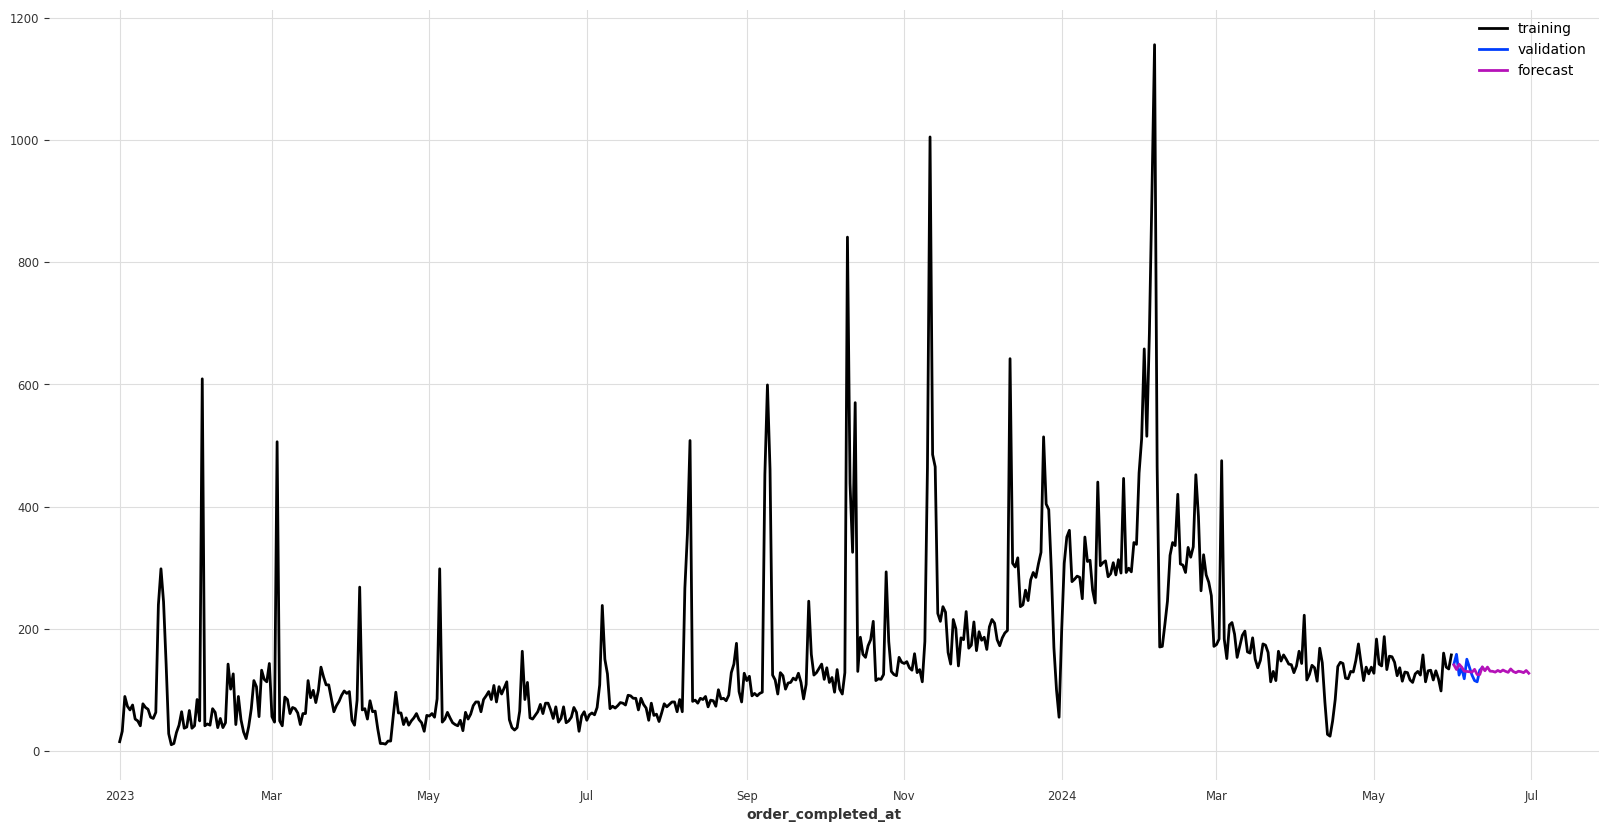

In [21]:
# # note random forset lag=1, max_depth=7, n_estimators=200
# lags_in = 27
# max_depths_in = 28
# n_estimators_in = 1000

# Rmodel = RandomForest(lags=lags_in, 
#                       max_depth=max_depths_in, 
#                       n_estimators=n_estimators_in
#                       )
# Rmodel.fit(ts_training)
pred = model_Rforest.predict(30)

plt.figure(figsize=(20, 10)) 

ts_training.plot(label="training")
ts_validation.plot(label="validation")
pred.plot(label="forecast")


In [24]:
from darts.metrics import mape, mse, mae, rmse
lags_in = 26
max_depths_in = 9
n_estimators_in = 400

best_mape = 100
for i in range(1,31):
    Rmodel = RandomForest(lags=lags_in, 
                        max_depth=max_depths_in, 
                        n_estimators=n_estimators_in
                        )
    Rmodel.fit(ts_training)
    pred_lr = Rmodel.predict(len(ts_validation))
    mape_value = mape(ts_validation, pred_lr)

    if mape_value < best_mape:
        Best_model = Rmodel
        best_mape = mape_value
        print(f'\nRandom Forest MAPE: lag {lags_in} max_depth {max_depths_in}  n_estimator {n_estimators_in} MAPE {mape_value}')
        print(f'MSE {mse(ts_validation, pred_lr)}')
        print(f'MAE {mae(ts_validation, pred_lr)}')
        print(f'RMSE {rmse(ts_validation, pred_lr)}\n')
    print(f'epoch {i}')


Random Forest MAPE: lag 26 max_depth 9  n_estimator 400 MAPE 9.724094723032145
MSE 227.08231550790242
MAE 12.769118606563781
RMSE 15.069250661791463

epoch 1

Random Forest MAPE: lag 26 max_depth 9  n_estimator 400 MAPE 8.697852410089594
MSE 180.0854952038327
MAE 11.342340168161146
RMSE 13.419593704871719

epoch 2

Random Forest MAPE: lag 26 max_depth 9  n_estimator 400 MAPE 8.495417599394267
MSE 191.51525809967407
MAE 11.067225136789062
RMSE 13.83890378966752

epoch 3
epoch 4

Random Forest MAPE: lag 26 max_depth 9  n_estimator 400 MAPE 7.774117330317366
MSE 146.02252559381654
MAE 10.153646624427031
RMSE 12.083978053348845

epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13

Random Forest MAPE: lag 26 max_depth 9  n_estimator 400 MAPE 7.682483538352527
MSE 148.86353422719142
MAE 10.076910293403662
RMSE 12.200964479384055

epoch 14
epoch 15

Random Forest MAPE: lag 26 max_depth 9  n_estimator 400 MAPE 7.464868137576126
MSE 152.65441577113947
MAE 9.847786887286

In [25]:
from darts.models import LinearRegressionModel, Prophet

Best_model.save("model/RandomForestModel_totalOrder_13Jun67_V1_1.pkl")

In [40]:
# Predict
best_model= RandomForest.load("model/RandomForestModel_totalOrder_13Jun67_V1_1.pkl")
best_model.fit(ts_order_quantity)

# ts_order_quantity.pd_dataframe().tail()

RandomForest(lags=26, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, output_chunk_shift=0, add_encoders=None, n_estimators=400, max_depth=9, multi_models=True, use_static_covariates=True)

In [41]:
forecast = best_model.predict(7)
forecast = forecast.pd_dataframe().reset_index()
forecast.columns = ['Date', 'Total Order']
forecast.tail(7)

,Date,Total Order
0,2024-06-13,130.334767
1,2024-06-14,139.756192
2,2024-06-15,132.781435
3,2024-06-16,133.895037
4,2024-06-17,133.616805
5,2024-06-18,131.536488
6,2024-06-19,131.807958


In [355]:
from darts.models import LinearRegressionModel, Prophet

best_model.save("model/RandomForestModel_totalOrder_13Jun67_V1_1.pkl")

# CatBoostModel

In [ ]:
from darts.models import (
    CatBoostModel
)

# สร้างและฝึก Linear Regression Model
best_lag = 1
for i in range(1,31):
    model_Cat = CatBoostModel(lags=i)
    model_Cat.fit(ts_training)

    # ทำนายค่าใน validation set
    pred_Cat = model_Cat.predict(len(ts_validation))

    # คำนวณค่า MAPE (Mean Absolute Percentage Error)
    error_lr = mape(ts_validation, pred_Cat)
    if i==1:
        error_best_lag = error_lr
    else:
        if error_lr < error_best_lag:
            error_best_lag = error_lr; best_lag = i

print(f'Linear Regression MAPE: lag {best_lag} {error_best_lag}')
print(f'MSE {mse(ts_validation, pred_Cat)}')
print(f'MAE {mae(ts_validation, pred_Cat)}')
print(f'RMSE {rmse(ts_validation, pred_Cat)}')